# Create a latitudinal summary for disturbance arrays

This notebook was used to develop the latitudinal summarys for disturbance arrays

In [17]:
import earthpy as et
from os import path
import numpy as np
import pandas as pd
from shapely import box
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
import gc

home = path.join(et.io.HOME, "GitHub", "visualize-forest-disturbance")

output_folder = path.join(et.io.HOME, "GitHub", "visualize-forest-disturbance", "data", "output")

home_tif = path.join(output_folder, "output_tifs")

forest_folder = path.join(home, "data", "input", "forest-disturbance-stack", "western-conus")

In [2]:
fire_int_path = path.join(home_tif, 'fire_stack.tif')
beetle_int_path = path.join(home_tif, 'beetle_stack.tif')
drought_int_path = path.join(home_tif, 'drought_stack.tif')
all_int_path = path.join(forest_folder, "total_disturbances.tif")

In [3]:
drought_lat_path = path.join(output_folder, "output_csvs", "drought_lat.csv")
fire_lat_path = path.join(output_folder, "output_csvs", "fire_lat.csv")
beetle_lat_path = path.join(output_folder, "output_csvs", "beetle_lat.csv")
all_lat_path = path.join(output_folder, "output_csvs", "all_lat.csv")

In [4]:
with rio.open(fire_int_path) as src:
    fire_crs = src.crs
    fire_array = src.read(1)
    fire_extent = plotting_extent(src)
    fire_meta = src.profile
    fire_transofrm = src.transform

fire_array[(fire_array > 0) & (fire_array < 255)] = 1

In [5]:
with rio.open(drought_int_path) as src:
    drought_array = src.read(1)
    drought_extent = plotting_extent(src)
    drought_meta = src.profile

drought_array[(drought_array > 0) & (drought_array < 255)] = 1

In [6]:
with rio.open(beetle_int_path) as src:
    beetle_array = src.read(1)
    beetle_extent = plotting_extent(src)
    beetle_meta = src.profile

beetle_array[(beetle_array > 0) & (beetle_array < 255)] = 1

In [7]:
with rio.open(all_int_path) as src:
    all_array = src.read(1)
    all_extent = plotting_extent(src)
    all_meta = src.profile

all_array[(all_array > 0) & (all_array < 255)] = 1

In [8]:
b = box(fire_extent[0], fire_extent[2], fire_extent[1], fire_extent[3])
g = gpd.GeoDataFrame(geometry = [b], crs=fire_crs).to_crs("EPSG:4326")
g.bounds

,minx,miny,maxx,maxy
0,-127.887457,29.252141,-101.360153,51.431376


In [9]:
def count_values_and_calculate_percent(array):
    """
    Processes a 2D array to count the number of 0s and 1s in each row,
    calculates the percentage of 1s, and returns a DataFrame with this information.
    Prints a progress update every 1000 rows.

    Parameters:
    array (np.ndarray): A 2D NumPy array containing 0s, 1s, and potentially other values.

    Returns:
    pd.DataFrame: DataFrame with columns 'Row', 'Count of 0s', 'Count of 1s', and 'Percent of 1s'.
    """
    num_rows = array.shape[0]
    rows = []
    count_zeros = []
    count_ones = []
    percent_ones = []
    totals = []

    for i, row in enumerate(array):
        if i % 10000 == 0:
            print(f"Processing row {i} of {num_rows}...")

        # Filter the row to include only 0s and 1s
        filtered_row = row[(row == 0) | (row == 1)]
        
        # Count occurrences of 0s and 1s
        count_zeros_row = np.sum(filtered_row == 0)
        count_ones_row = np.sum(filtered_row == 1)
        total_count = count_zeros_row + count_ones_row
        
        # Calculate percentage of 1s
        percent_ones_row = (count_ones_row / total_count) * 100 if total_count > 0 else 0
        
        # Append results
        rows.append(i)
        count_zeros.append(count_zeros_row)
        count_ones.append(count_ones_row)
        percent_ones.append(percent_ones_row)
        totals.append(total_count)

    # Create a DataFrame from the collected data
    df = pd.DataFrame({
        'Row': rows,
        'Count of 0s': count_zeros,
        'Count of 1s': count_ones,
        'Total' : totals,
        'Percent of 1s': percent_ones
    })

    return df


In [10]:
def summarize_by_1000_rows(df):
    """
    Summarizes the DataFrame by aggregating the percentages over every 1000 rows
    and stores these aggregated values with the first index of each summarized area.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'Row' and 'Percent of 1s' columns.

    Returns:
    pd.DataFrame: DataFrame with summarized data.
    """
    # Determine the number of rows
    num_rows = df.shape[0]
    
    # Calculate the number of groups (each containing 1000 rows)
    num_groups = (num_rows + 999) // 1000
    
    # Initialize lists to hold summary data
    summarized_rows = []
    summarized_percentages = []
    
    # Process each group
    for group in range(num_groups):
        start_index = group * 1000
        end_index = min((group + 1) * 1000, num_rows)
        
        # Select the subset of the DataFrame
        subset = df.iloc[start_index:end_index]
        
        # Sum the percentages in this group
        total_percentage = subset['Percent of 1s'].sum()
        
        # Store the result with the first index of the group
        summarized_rows.append(int(df.iloc[start_index]['Row']))
        summarized_percentages.append(total_percentage / (end_index - start_index))
    
    # Create a summarized DataFrame
    summarized_df = pd.DataFrame({
        'Row': summarized_rows,
        'Percent of 1s': summarized_percentages
    })
    
    return summarized_df

In [11]:
fire_df = count_values_and_calculate_percent(fire_array)
fire_df.to_csv(fire_lat_path)

Processing row 0 of 72692...
Processing row 10000 of 72692...
Processing row 20000 of 72692...
Processing row 30000 of 72692...
Processing row 40000 of 72692...
Processing row 50000 of 72692...
Processing row 60000 of 72692...
Processing row 70000 of 72692...


In [12]:
drought_df = count_values_and_calculate_percent(drought_array)
drought_df.to_csv(drought_lat_path)

Processing row 0 of 72692...
Processing row 10000 of 72692...
Processing row 20000 of 72692...
Processing row 30000 of 72692...
Processing row 40000 of 72692...
Processing row 50000 of 72692...
Processing row 60000 of 72692...
Processing row 70000 of 72692...


In [13]:
beetle_df = count_values_and_calculate_percent(beetle_array)
beetle_df.to_csv(beetle_lat_path)

Processing row 0 of 72692...
Processing row 10000 of 72692...
Processing row 20000 of 72692...
Processing row 30000 of 72692...
Processing row 40000 of 72692...
Processing row 50000 of 72692...
Processing row 60000 of 72692...
Processing row 70000 of 72692...


In [14]:
all_df = count_values_and_calculate_percent(all_array)
all_df.to_csv(all_lat_path)

Processing row 0 of 72692...
Processing row 10000 of 72692...
Processing row 20000 of 72692...
Processing row 30000 of 72692...
Processing row 40000 of 72692...
Processing row 50000 of 72692...
Processing row 60000 of 72692...
Processing row 70000 of 72692...


In [19]:
del(fire_array)
del(beetle_array)
del(all_array)
del(drought_array)
gc.collect()

1027

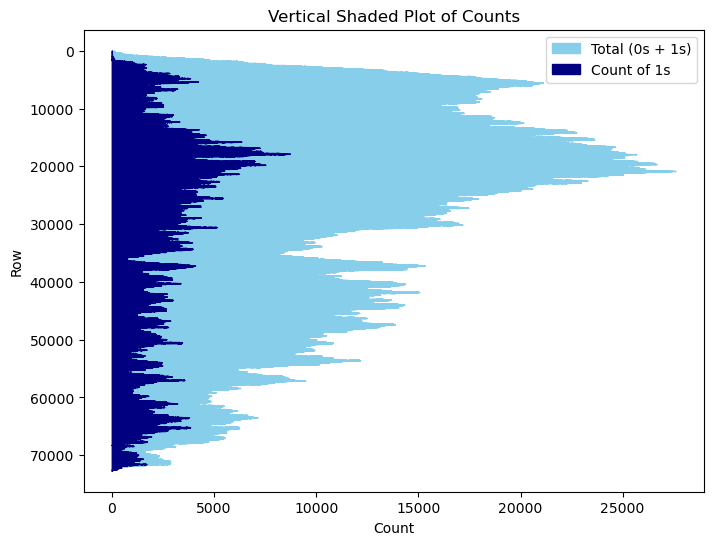

In [15]:
plt.figure(figsize=(8, 6))
plt.fill_betweenx(fire_df['Row'], 0, fire_df['Total'], color='skyblue', label='Total (0s + 1s)')
plt.fill_betweenx(fire_df['Row'], 0, fire_df['Count of 1s'], color='navy', label='Count of 1s')

plt.xlabel('Count')
plt.ylabel('Row')
plt.title('Vertical Shaded Plot of Counts')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest row number at the top
plt.show()
